In [ ]:
from __future__ import print_function

#Numpy, pandas ans os
import numpy as np
import pandas as pd
import os
# matplotlib for displaying the output
import matplotlib.pyplot as plt

# Librosa for audio
import librosa


#parselmouth for audio
import parselmouth
from parselmouth.praat import call
from sklearn.decomposition import PCA
import statistics

#essentia

import essentia.standard
import essentia.streaming
from essentia.standard import *


#librairies for classification
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, make_scorer, confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import GridSearchCV
import joblib

#Deep learning

### Plot imports ###

import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import load_model
import seaborn as sns 
from keras.utils import np_utils
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder

#for warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category= ConvergenceWarning)

warnings.filterwarnings("ignore", category= UserWarning)
warnings.filterwarnings("ignore", category= RuntimeWarning)

Dataframe to match audio with emotion

In [7]:
parent_dir = "ravdess" #audio data folder
def prepare_datadf(parent_dir): # a function whose parameter is the audio folder
    df = pd.DataFrame(columns = ['audio', 'label']) #dataframe columns
    
    for  fichier_audio in os.listdir(parent_dir): # for each element in the audio folder
        folder_path = os.path.join(parent_dir, fichier_audio) # path of each item  in the audio folder
        
       
        
        if(os.path.isdir(folder_path)): 
            audios = os.listdir(folder_path) #content of each emotional file
            for i in audios:
                emotion = None
                if i.endswith('outNoise.wav'):
                    if i[7] == '7':      ##this specifies that we class disgust emotion against the others
                                    #7 represents the 7th column of the file name
                                    # This number varies for each emotion(ex calm = '2', fearfull = '6')
                        emotion = 1
                    
                    else:
                        emotion = 0
                    df = df.append(pd.DataFrame({'audio':[os.path.join(fichier_audio, i)], 'label':[emotion]}), 
                           ignore_index=True) #adding values to the defined df:
                                            #the audio column will take the audios_path, 
                                            #and the emotion column will take the corresponding emotion, ie the name of the folder
    #Shuffling for randomness
    df = df.sample(frac=1.0).reset_index(drop=True)
    return df
datadf = prepare_datadf(parent_dir) #function call
display(datadf.head()) #dataframe display

	

,audio,label
0,fearfull/03-01-06-02-02-01-24_norm_outNoise.wav,0
1,disgust/03-01-07-02-02-01-12_norm_outNoise.wav,1
2,angry/03-01-05-02-01-02-06_norm_outNoise.wav,0
3,surprised/03-01-08-01-01-01-20_norm_outNoise.wav,0
4,disgust/03-01-07-01-02-02-08_norm_outNoise.wav,1


Number of labels 1 and 0

In [8]:
array=datadf.values
audios=array[:,0]
emotions=array[:,1]
print(datadf.label.value_counts())

0    1053
1     192
Name: label, dtype: int64


Preprocessing

Function for framing and windowing the audio_files

In [9]:
def fram_window(audio_path):
    loader = essentia.standard.MonoLoader(filename= audio_path)

    # and then we actually perform the loading:
    audio = loader()

    w = Windowing(type = 'hann')
    spectrum = Spectrum() 
    #default parameter (hopsize and framesize)
    hopSize = 512
    frameSize = 1024 
    for frame in FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=True):
        spect = spectrum(w(frame))
    return spect

function for features extraction:

In [10]:
def extract_features(audio_path):
    features = []
    
    
    #Load audios with the different libraries
      
    y,sr = librosa.load(audio_path)
    sound = parselmouth.Sound(audio_path)
    fs, sig = scipy.io.wavfile.read(audio_path) 
    
    pitch = call(sound, "To Pitch", 0.0, 75, 600)
    mean_pitch = call(pitch, "Get mean", 0, 0, "Hertz")
    
    spec =  fram_window(audio_path) 
    duration = librosa.get_duration(y= spec, sr=sr)
    energy = np.sum(spec ** 2) / np.float64(len(spec))
            
    lpc = librosa.core.lpc(spec,16)
            
    zcr = librosa.feature.zero_crossing_rate(spec)
               
    #gfccs = gfcc(sig= spec, fs=fs, num_ceps=13)    
    mfcc = librosa.feature.mfcc(y= spec, sr=sr, n_mfcc = 13)
        
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    HNR = call(harmonicity, "Get mean", 0, 0)
                
    pointProcess = call(sound, "To PointProcess (periodic, cc)", 75, 500)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)

    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
        
    formants = call(sound, "To Formant (burg)", 0.0, 5, 5500, 0.025, 100)
    numPoints = call(pointProcess, "Get number of points")

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
        
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']

    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)
    f3_mean = statistics.mean(f3_list)
    f4_mean = statistics.mean(f4_list)
    
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)   
            
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    features.append(mean_pitch)
    features.append(duration)
    features.append(energy)
    features.append(np.mean(zcr))
    features.append(np.mean(lpc))
    
        
    features.append(np.mean(mfcc))
    
    #features.append(np.mean(gfccs))
    features.append(HNR)
    
    features.append(localJitter)
    features.append(np.mean(localabsoluteJitter))
    
    features.append(localShimmer)
    features.append(localdbShimmer)
    features.append(f1_mean)   
    features.append(f2_mean)
    features.append(f3_mean)
    features.append(f4_mean)
        
    features.append(rapJitter)
    features.append(ppq5Jitter)
    features.append(ddpJitter)
    
    features.append(apq3Shimmer)
    features.append(aqpq5Shimmer)
    features.append(apq11Shimmer)
    features.append(ddaShimmer)
        
    return features

Application of features extraction function on all audios

In [11]:
all_features = []
for audio_file in array[:,0]:
    if audio_file.endswith('.wav'):
        
        features = extract_features(parent_dir+'/'+audio_file)
        all_features.append(features)

In [12]:
print(len(all_features))

1245


Encode labels

In [13]:
encod = preprocessing.LabelEncoder()
emotions = array[:,1]
encod.fit(emotions)
list(encod.classes_)
labels=encod.transform(emotions)

Scale features

In [14]:
scaler = StandardScaler()
scaler.fit(all_features)
X_scaler = scaler.transform(all_features)

Oversampling

In [15]:
ada = ADASYN(sampling_strategy = 0.6)
X, y = ada.fit_sample(X_scaler, labels.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y==0)))

After OverSampling, counts of label '1': 596
After OverSampling, counts of label '0': 1053


Process to select features after oversampling with ADASYN : the code first takes in a list the position of the features that are deleted, during the 1000 iterations, then uses a dataframe to count them. we notice that the features " [1, 2, 3, 5, 8, 14, 20]   " are deleted 900 times.

In [16]:
compt=0
df = pd.DataFrame(columns = ['iteration', 'X_removed'])
while compt < 1000:
    ada = ADASYN(sampling_strategy = 0.6)
    
    X, y = ada.fit_sample(X_scaler, labels.ravel())
    X = np.asarray(X)
    Kbest = SelectKBest(k="all")
    selec_features = Kbest.fit(X, y)
    alpha = 0.01
    #remove non_signifiant features selection
    X_selec = X[:,np.where(selec_features.pvalues_ < alpha)[0]]
    
    pos_removed = []    
    for i in range(len(X[0])):
   
        if X[0][i] not in X_selec[0]:
            #print(i)
            pos_removed.append(i)
            str_pos_removed = str(pos_removed)
    #print(pos_removed)
    
    compt = compt + 1
    df= df.append(pd.DataFrame({'iteration':[compt], 'X_removed':[str_pos_removed]}), ignore_index=True)
display(df.head())

print("Number of occurrences of features that are removed :")
df["X_removed"].value_counts()

,iteration,X_removed
0,1,"[1, 2, 3, 5, 8, 14, 20]"
1,2,"[1, 2, 3, 5, 8, 14, 20]"
2,3,"[1, 2, 3, 5, 8, 14, 20]"
3,4,"[1, 2, 3, 5, 8, 14, 20]"
4,5,"[1, 2, 3, 5, 8, 14, 20]"


Number of occurrences of features that are removed :


[1, 2, 3, 5, 8, 14, 20]    900
[1, 2, 3, 8, 14, 20]       100
Name: X_removed, dtype: int64

In [17]:
#manually feature selection
X_selected = []
for i in range(len(X)):
    #print(w[i][0])
    X_selected.append([X[i][0],  X[i][4], X[i][6], X[i][7], X[i][9], X[i][10],
               X[i][11], X[i][12], X[i][13],  X[i][15], 
                X[i][16], X[i][17], X[i][18], X[i][19], X[i][21]])

Split dataset to Train, Test and Val

In [18]:
#split train test
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1)

print(len(X_train))
print(len(X_test))
print(len(X_val))

1055
330
264


Reshape Labels and features for deep learning model

Features

In [20]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_val = np.asarray(X_val)

In [21]:
 X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
 X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
 X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

 print(X_train.shape)
 print(X_test.shape)
 print(X_val.shape)

(1055, 15, 1)
(330, 15, 1)
(264, 15, 1)


labels

In [22]:

from keras.utils import to_categorical

# Encode the classification labels
le = LabelEncoder()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


(1055, 2)
(330, 2)
(264, 2)


### Classification 

Model

In [23]:
input_y = Input(shape= (15,1))

In [25]:
#CNN 
y = Conv1D(256, kernel_size=5, strides= 1,  name='Conv_1', padding = 'same')(input_y)
y = BatchNormalization( name='BatchNorm_1')(y)
y = Activation('elu', name='Activ_1')(y)

y = Conv1D(128, kernel_size=5, strides= 1,  name='Conv_2', padding = 'same')(input_y)
y = Activation('elu', name='Activ_2')(y)

y = Dropout(0.2, name='Drop_1')(y)
y = BatchNormalization( name='BatchNorm_2')(y)
y = MaxPooling1D(pool_size=8, name = 'maxpooling', padding = 'same') (y) 

y = Conv1D(128, kernel_size= 5, strides= 1,  name='Conv_3', padding = 'same')(y)
y = Activation('elu', name='Activ_3')(y)

y = Conv1D(128, kernel_size= 5, strides= 1,  name='Conv_4', padding = 'same')(y)
y = Activation('elu', name='Activ_4')(y)

y = Conv1D(128, kernel_size=5, strides= 1,  name='Conv_5', padding = 'same')(input_y)
y = BatchNormalization( name='BatchNorm_3')(y)
y = Activation('elu', name='Activ_5')(y)

y = Dropout(0.2, name='Drop_2')(y)     

y = Conv1D(128, kernel_size= 5, strides= 1,  name='Conv_6', padding = 'same')(y)

y = Flatten(name='Flat')(y)
y = Dropout(0.2, name='Drop_3')(y)  

y = Dense(y_train.shape[1],  name='dense')(y)

y = BatchNormalization(name='BatchNorm_4')(y)

y = Activation('softmax', name='Activ_6')(y)









# Build final model
model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1)]           0         
_________________________________________________________________
Conv_5 (Conv1D)              (None, 15, 128)           768       
_________________________________________________________________
BatchNorm_3 (BatchNormalizat (None, 15, 128)           512       
_________________________________________________________________
Activ_5 (Activation)         (None, 15, 128)           0         
_________________________________________________________________
Drop_2 (Dropout)             (None, 15, 128)           0         
_________________________________________________________________
Conv_6 (Conv1D)              (None, 15, 128)           82048     
_________________________________________________________________
Flat (Flatten)               (None, 1920)              0   

In [26]:

METRICS = [
      
      keras.metrics.BinaryAccuracy(name='accuracy'),
      
      keras.metrics.AUC(name='auc'),
]


In [27]:
# Compile model
model.compile(optimizer=RMSprop(lr=0.00001, decay=1e-6), loss='categorical_crossentropy', metrics=[METRICS])

# Save best model
best_model_save = ModelCheckpoint('disgust_ravdess.hdf5', save_best_only=True, monitor='val_loss', mode='auto')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 30,  verbose=1, mode='auto')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=700, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Epoch 1/700
17/17 [==============================] - 1s 48ms/step - loss: 0.8634 - accuracy: 0.5346 - auc: 0.5355 - val_loss: 0.6976 - val_accuracy: 0.5182 - val_auc: 0.5127
Epoch 2/700
17/17 [==============================] - 0s 26ms/step - loss: 0.7815 - accuracy: 0.5526 - auc: 0.5761 - val_loss: 0.6823 - val_accuracy: 0.5727 - val_auc: 0.5804
Epoch 3/700
17/17 [==============================] - 0s 26ms/step - loss: 0.7254 - accuracy: 0.5905 - auc: 0.6113 - val_loss: 0.6724 - val_accuracy: 0.5758 - val_auc: 0.6266
Epoch 4/700
17/17 [==============================] - 0s 26ms/step - loss: 0.6959 - accuracy: 0.5754 - auc: 0.6165 - val_loss: 0.6639 - val_accuracy: 0.5970 - val_auc: 0.6611
Epoch 5/700
17/17 [==============================] - 0s 26ms/step - loss: 0.6777 - accuracy: 0.6114 - auc: 0.6479 - val_loss: 0.6589 - val_accuracy: 0.6030 - val_auc: 0.6746
Epoch 6/700
17/17 [==============================] - 0s 26ms/step - loss: 0.6610 - accuracy: 0.6133 - auc: 0.6688 - val_loss: 0.65

In [30]:

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('(True Negatives): ', cm[0][0])
  print('(False Positives): ', cm[0][1])
  print('(False Negatives): ', cm[1][0])
  print('(True Positives): ', cm[1][1])
  print('Total emotions_happy: ', np.sum(cm[1]))


test prediction


loss :  0.5685762763023376
accuracy :  0.678787887096405
auc :  0.7584205865859985

(True Negatives):  129
(False Positives):  72
(False Negatives):  34
(True Positives):  95
Total emotions_happy:  129
              precision    recall  f1-score   support

           0       0.79      0.64      0.71       201
           1       0.57      0.74      0.64       129

    accuracy                           0.68       330
   macro avg       0.68      0.69      0.68       330
weighted avg       0.70      0.68      0.68       330



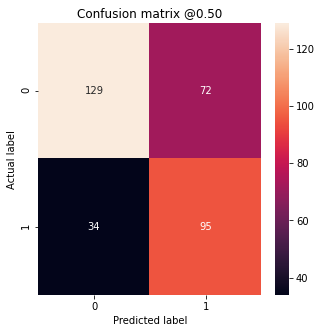

In [31]:
model = load_model('disgust_ravdess.hdf5')
test_predictions_baseline = model.predict(X_test)
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size= 64, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

y_pred = np.argmax(test_predictions_baseline, axis= 1)
yy_test = np.argmax(y_test, axis  = 1)
plot_cm(yy_test, y_pred)

print(classification_report(yy_test, y_pred))



Validation

loss :  0.5591848492622375
accuracy :  0.7121211886405945
auc :  0.7826848030090332

(True Negatives):  125
(False Positives):  60
(False Negatives):  16
(True Positives):  63
Total emotions_happy:  79
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       185
           1       0.51      0.80      0.62        79

    accuracy                           0.71       264
   macro avg       0.70      0.74      0.70       264
weighted avg       0.77      0.71      0.72       264



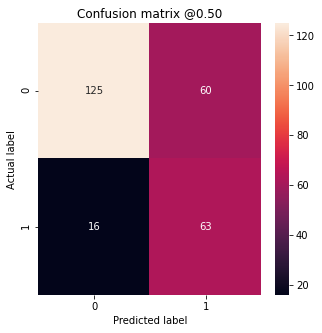

In [33]:

val_predictions_baseline = model.predict(X_val)
baseline_results = model.evaluate(X_val, y_val,
                                  batch_size= 64, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

y_pred_val = np.argmax(val_predictions_baseline, axis= 1)
yy_val = np.argmax(y_val, axis  = 1)
plot_cm(yy_val, y_pred_val)

print(classification_report(yy_val, y_pred_val))

